In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

In [2]:
customers_data = pd.read_csv('Customers.csv')

In [3]:
transactions_data = pd.read_csv('Transactions.csv')

In [4]:
customers_data['SignupDate'] = pd.to_datetime(customers_data['SignupDate'])
transactions_data['TransactionDate'] = pd.to_datetime(transactions_data['TransactionDate'])

In [5]:
merged_data = pd.merge(transactions_data, customers_data, on='CustomerID', how='inner')

In [6]:
customer_summary = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',       
    'Quantity': 'sum',         
    'TransactionID': 'count',  
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
}).reset_index()

In [7]:
final_data = pd.merge(customer_summary, customers_data, on='CustomerID', how='inner')

In [8]:
clustering_features = final_data[['TotalSpent', 'TotalQuantity', 'TransactionCount']]

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

In [10]:
db_indices = []
kmeans_models = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    kmeans_models.append(kmeans)
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_indices.append(db_index)


In [11]:
optimal_k = 2 + db_indices.index(min(db_indices))

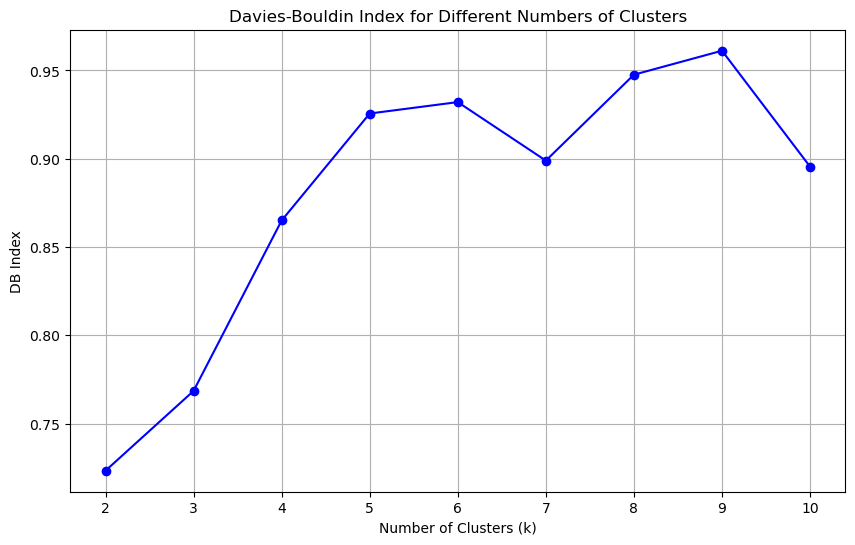

Optimal number of clusters: 2


In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_indices, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

print(f"Optimal number of clusters: {optimal_k}")

In [13]:
final_kmeans = kmeans_models[optimal_k - 2]
final_data['Cluster'] = final_kmeans.labels_

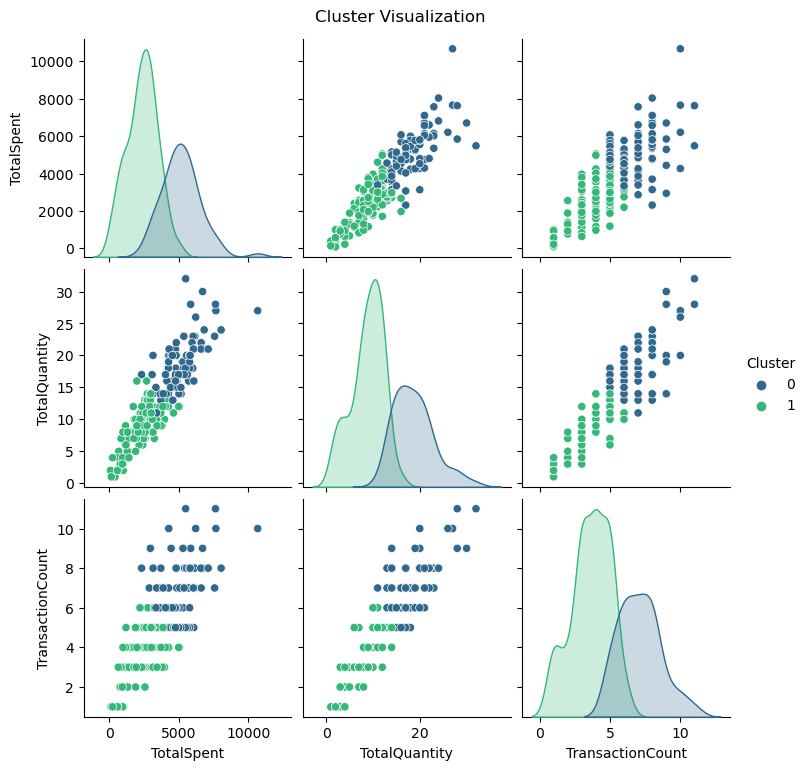

In [14]:
sns.pairplot(
    final_data,
    vars=['TotalSpent', 'TotalQuantity', 'TransactionCount'],
    hue='Cluster',
    palette='viridis',
    diag_kind='kde',
    height=2.5
)
plt.suptitle('Cluster Visualization', y=1.02)
plt.show()

In [15]:
centroids = pd.DataFrame(
    scaler.inverse_transform(final_kmeans.cluster_centers_),
    columns=['TotalSpent', 'TotalQuantity', 'TransactionCount']
)
print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
    TotalSpent  TotalQuantity  TransactionCount
0  5155.752532      18.721519          7.113924
1  2355.759250       8.816667          3.650000
